In [2]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..', '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga



Populating the interactive namespace from numpy and matplotlib


In [3]:
full_ds = loompy.connect(f'../data/complete_processing/stage6.processed.loom', 'r')
full_ds.vals = sp.sparse.csr_matrix(full_ds.layers[""][:, :])


### Make a copy of the data, keeping only exocrine cells 

In [4]:
%mkdir ../data/exocrine/
attributes_to_copy = ['CellID', 'CellBatch', 'CellWeek', 'CellFlask', 'DetailedLabels', 'Labels', '_TrainFilter', '_Valid']

f_cells = np.where(full_ds.ca.Labels == 'exo')[0]
min_cells_per_valid_gene = 10
%rm f'../data/complete_processing/stage6.exo.loom'
loompy.create(f'../data/complete_processing/stage6.exo.loom',
              {'': full_ds.vals[:, f_cells]},
              {'Gene': full_ds.ra.Gene,
               '_Valid': (full_ds.vals[:, f_cells].sum(1).A.ravel() > min_cells_per_valid_gene),
               '_Regress': (full_ds.vals[:, f_cells].sum(1).A.ravel() > min_cells_per_valid_gene),
                  },
              {a: full_ds.ca[a][f_cells] for a in attributes_to_copy},
             )
full_ds.close()

### Analysis the exocrine cells

In [5]:
import json
with open('../../01_Stages_3_to_6/data/original/cell_cycle_genes.json', 'r') as f:
    cell_cycle_set = set(json.load(f))
     

In [7]:
ds = loompy.connect(f'../data/complete_processing/stage6.exo.loom')
ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])

In [8]:
seed = 8918331

_valid_genes = ds.ra._Valid
_valid_genes[np.where(np.isin(ds.ra.Gene, list(cell_cycle_set)))[0]] = 0
ds.ra._Valid = _valid_genes

train_cells = np.where((ds.ca['_TrainFilter'] > 0) & (ds.ca['CellWeek'] > 0))[0]

cga.highvar_pca(ds, ds.vals, namespace='Raw', seed=seed,
            train_cells=train_cells,
            n_highvar_pcs=50,
            n_highvar_genes=2000)

In [11]:
ds.ca["RawHighVarTSNE"] = cg.TSNE(perplexity=100).layout(ds.ca[r"RawHighVarPCA"][:, :25])

In [ ]:
labels = cga.mknn_leiden_labels(input_space=ds.ca[r"RawHighVarPCA"][:, :25], clustering_resolution=1.0)
ds.ca["RawLabels"] = labels.original

#### We do a first pass of clustering

We noticed that there is a small cluster (5 below) that seems to have higher expression of endocrine genes. We noted that these cells seem to be exocrine cells, with some ambient RNA contamination (the expression levels for the endocrine genes, when compared to bona fide endocrine genes are very small). To prevent these cells from confusing the non-endocrine analysis, we exclude them during the fit of the principal components.

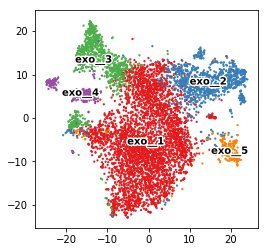

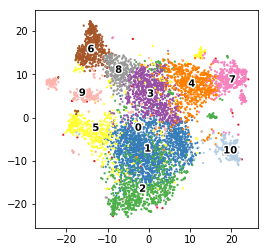

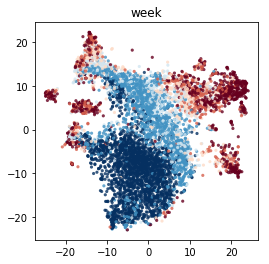

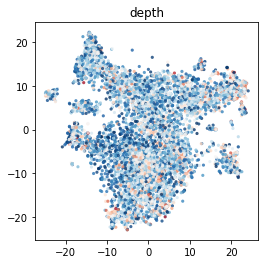

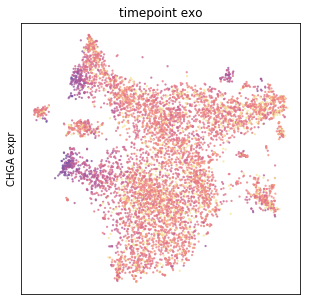

In [12]:
vis.scatter_cat(ds.ca["RawHighVarTSNE"], ds.ca.DetailedLabels)
vis.scatter_cat(ds.ca["RawHighVarTSNE"], ds.ca["RawLabels"])
vis.scatter_cont(ds.ca["RawHighVarTSNE"], ds.ca['CellWeek'], title='week')
vis.scatter_cont(ds.ca["RawHighVarTSNE"], np.log10(ds.ca.RawNormalizerTotals), title='depth')
vis.plot_gene_by_time_point({'exo':ds}, ['CHGA'])

In [13]:
ds.ca['HighEndoMix'] = ((ds.ca["RawLabels"] == 5)).astype(int)

In [14]:
seed = 9281921

_valid_genes = ds.ra._Valid
_valid_genes[np.where(np.isin(ds.ra.Gene, list(cell_cycle_set)))[0]] = 0
ds.ra._Valid = _valid_genes

train_cells = np.where((ds.ca['_TrainFilter'] > 0) & (ds.ca['CellWeek'] > 0) & (ds.ca['HighEndoMix'] == 0))[0]

cga.highvar_pca(ds, ds.vals, namespace='Filtered', seed=seed,
            train_cells=train_cells,
            n_highvar_pcs=50,
            n_highvar_genes=1000)

In [15]:
ds.ca["TSNE"] = cg.TSNE(perplexity=200, max_iter=10000).layout(ds.ca[r"FilteredHighVarPCA"][:, :10])

In [16]:
labels = cga.mknn_leiden_labels(input_space=ds.ca[r"FilteredHighVarPCA"][:, :10],
                                clustering_resolution=1.5, seed=182112)
ds.ca["Labels"] = labels.original

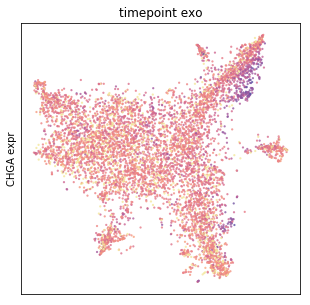

In [19]:
# The CHGA cells are fixed by the correctionf from above
vis.plot_gene_by_time_point({'exo':ds}, ['CHGA'], tsne_attr='TSNE')

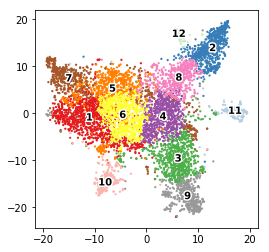

In [20]:
vis.scatter_cat(ds.ca["TSNE"], ds.ca["Labels"], min_elements_for_label=0)

#### Annotate the labels and do a classifier update

In [21]:
autolabel_enrichment = utils.load_df(f'../data/clustering/exo.autolabels.df.npz')

In [22]:
pb_labels = cgm.CellLabels(ds.ca['Labels'])
cluster_pseudobulk = cga.pseudobulk_from_label(ds, pb_labels)
cluster_pseudobulk_z = ((cluster_pseudobulk - cluster_pseudobulk.mean())/cluster_pseudobulk.std()).fillna(0.0)
        
autolabel_corr = pd.DataFrame(utils.two_array_corr((autolabel_enrichment > 0).astype(float).values,
                                                   cluster_pseudobulk_z.T.loc[autolabel_enrichment.index].values),
                                 columns = autolabel_enrichment.columns,
                                 index=cluster_pseudobulk_z.T.columns)

In [23]:
autolabel_calls = autolabel_corr.idxmax(1)
autolabel_calls = autolabel_calls.to_dict()
autolabel_calls[0] = ''

ann_labels = cgm.CellLabels(np.array([autolabel_calls[li] for li in pb_labels.original]), null_label='')
ds.ca['AnnotatedLabels'] = ann_labels.original

In [24]:
classifier_labels = cga.update_labels_with_classifier(ds, ann_labels, seed=9381241,
                                                      input_space_attr="FilteredHighVarPCA", 
                                                      recovery_classification_threshold=0.66)
ds.ca['ExoLabels'] = classifier_labels.original

### Output the pseudobulk values

In [25]:
full_labels = cgm.CellLabels(ds.ca.ExoLabels, null_label="")

for _labels, label_name in [
                        (full_labels, 'labels'),]:
    

    tp_pb = cga.pseudobulk_from_label(ds, _labels, norm_total=10**6)
    tp_expr = cga.expressed_fraction_from_label(ds, _labels)
    
    utils.save_df(tp_pb, f'../data/complete_processing/exo.{label_name}.pseudobulk_tpm.df.npz')
    utils.save_df(tp_expr, f'../data/complete_processing/exo.{label_name}.expr_frac.df.npz')